# IRWA Project part 1

### Uzair Ramzan Parveen - U199323
### Marc Riera Arza - U
### Payden Reed Knettles - U250322

## Imports and Data Loading


In this section, we have the code that carries out the necessary imports for the project and the loading of the input data.

In [ ]:
# Run if ntlk package not installed
# pip install nltk

In [ ]:
# imports

import wordcloud
from wordcloud import WordCloud
import json
from collections import defaultdict
from array import array
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# mounting drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data loading

file_path = '/content/drive/MyDrive/IR_G102_10/Part1/data/farmers-protest-tweets.json'    # Check path

tweets_data = []
with open(file_path, 'r') as file:
    for line in file:
        try:
            tweet = json.loads(line)  # Load each line as a separate JSON object
            tweets_data.append(tweet)  # Append to the list
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")


## Data Preprocessing

In this section, we have the code for the function that we will use to preprocess our input data to remove extra data and only keep the desired fields.

### Preprocessing function

In [ ]:
# Initializing stemmer

stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def line_processor(tweet_data):

    # Extract key fields from the tweet data
    tweet_content = tweet_data.get("content", "")
    tweet_date = tweet_data.get("date", "")
    tweet_url = tweet_data.get("url", "")
    tweet_likes = tweet_data.get("likeCount", 0)
    tweet_retweets = tweet_data.get("retweetCount", 0)
    tweet_id = tweet_data.get("id", "")

    # Split tweet content to extract hashtags
    basic_split = tweet_content.split()
    hashtags = [word for word in basic_split if word.startswith("#")]

    # Tokenization: word separation
    tokens = word_tokenize(tweet_content)

    # Cleaning: Remove stopwords, punctuation, non-alphanumeric, and stemming
    relevant_tokens = [
        stemmer.stem(token.lower()) for token in tokens
        if token.isalnum() and token.lower() not in stop_words and len(token) > 2
    ]

    # Rebuild the cleaned tweet content
    cleaned_tweet = ' '.join(relevant_tokens)

    # Return the processed data
    return {
        "Content": cleaned_tweet,
        "Date": tweet_date,
        "Likes": tweet_likes,
        "Retweets": tweet_retweets,
        "URL": tweet_url,
        "Hastags":hashtags,
        "ID": tweet_id
    }



In [ ]:
# Example of usage with tweet data

processed_tweet = line_processor(tweets_data[0])
print(processed_tweet)

{'Content': 'world progress indian polic govt still tri take india back horrif past tyranni narendramodi delhipolic shame modidontsellfarm farmersprotest freenodeepkaur http', 'Date': '2021-02-24T09:23:35+00:00', 'Likes': 0, 'Retweets': 0, 'URL': 'https://twitter.com/ArjunSinghPanam/status/1364506249291784198', 'Hastags': ['#ModiDontSellFarmers', '#FarmersProtest', '#FreeNodeepKaur'], 'ID': 1364506249291784198}


### Preprocessing tweets

In this section, we are applying the processing function implemented previously to process our data and converting it to a dataframe with the desired fields as columns and the tweet ID as index.

In [ ]:
# List to store processed tweet data
processed_data = []

# Process each tweet and append the result to the list
for tweet in tweets_data:
    data = line_processor(tweet)
    processed_data.append(data)

# Create DataFrame from the list in one go
tweets_df = pd.DataFrame(processed_data)

# Set the 'ID' column as the index
tweets_df.set_index("ID", inplace=True)

# Limiting the Date column to date only
tweets_df['Date'] = pd.to_datetime(tweets_df['Date'])
tweets_df['Date'] = tweets_df['Date'].dt.date

In [ ]:
# Presentation of the processed data in a dataframe
tweets_df.head(4)


,Content,Date,Likes,Retweets,URL,Hastags
ID,,,,,,
1364506249291784198,world progress indian polic govt still tri tak...,2021-02-24,0,0,https://twitter.com/ArjunSinghPanam/status/136...,"[#ModiDontSellFarmers, #FarmersProtest, #FreeN..."
1364506237451313155,farmersprotest modiignoringfarmersdeath modido...,2021-02-24,0,0,https://twitter.com/PrdeepNain/status/13645062...,"[#FarmersProtest, #ModiIgnoringFarmersDeaths, ..."
1364506195453767680,farmersprotest,2021-02-24,0,0,https://twitter.com/parmarmaninder/status/1364...,[#FarmersProtest]
1364506167226032128,reallyswara watch full video http farmersprote...,2021-02-24,0,0,https://twitter.com/anmoldhaliwal/status/13645...,"[#farmersprotest, #NoFarmersNoFood]"


## Exploratory Data Analysis

In this section, we will carry out multiple tasks in order to understand our data and to have some visual support for the decisions to be made later on.

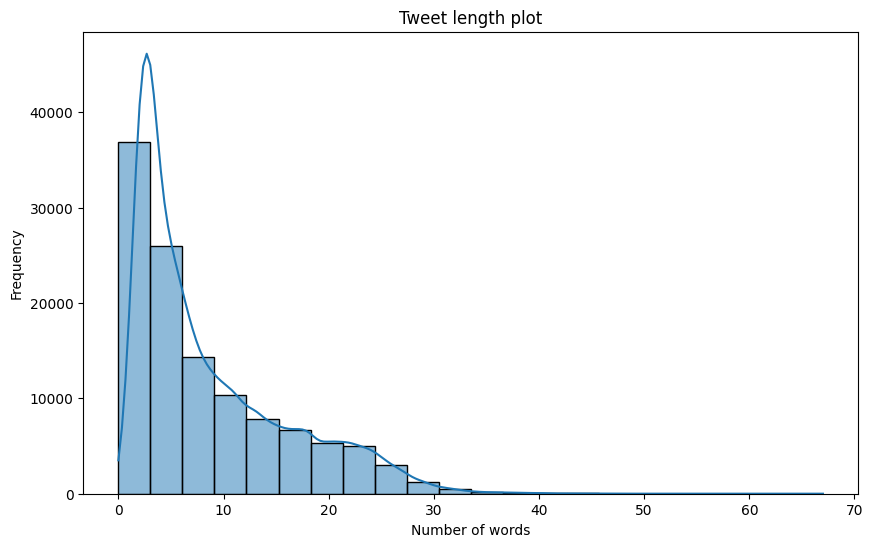

In [ ]:
# Tweet length plot

# Aux column for the length of each
vocab_df = tweets_df.copy()
vocab_df['Wordcount'] = tweets_df['Content'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
sns.histplot(vocab_df['Wordcount'], bins=22, kde=True)

plt.title('Tweet length plot')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()

*explain the distribution and comment on the axes in general..also comment on how the distribution is the same in both plots since they represent the same concept basically*

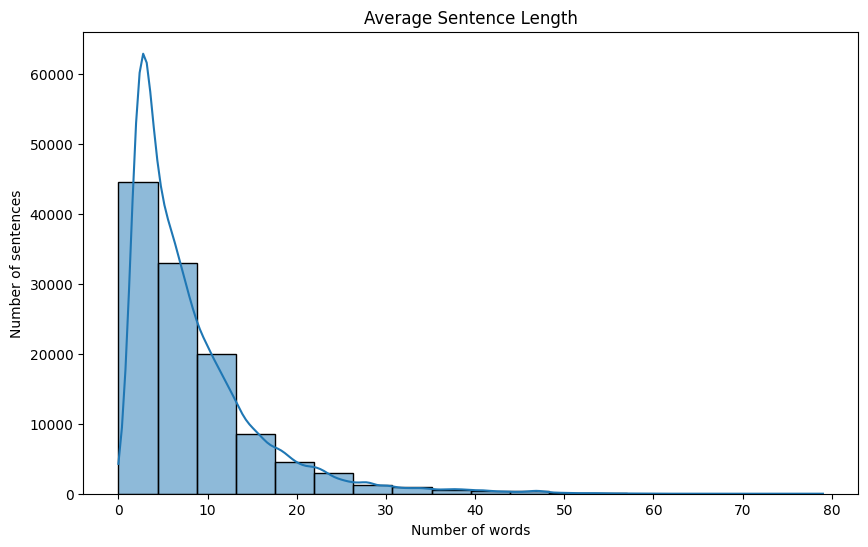

In [ ]:
# Average sentence length plot

# Getting raw tweet content
raw_content = [tweet['content'] for tweet in tweets_data]

# Function to calculate average sentence length in a tweet
def avg_SL(tc):
  sents = sent_tokenize(tc)
  num_sents = len(sents)
  words = word_tokenize(tc)
  num_words = sum(1 for word in words if word.isalnum())
  return num_words/num_sents if num_sents > 0 else 0

avg_lengths = [avg_SL(content) for content in raw_content]

plt.figure(figsize=(10,6))
sns.histplot(avg_lengths, bins=18, kde=True)
plt.title('Average Sentence Length')
plt.xlabel('Number of words')
plt.ylabel('Number of sentences')
plt.show()

In [ ]:
# Getting info. about our vocabulary

# Getting all the tweets' content in a single list of words
whole_content = tweets_df['Content'].str.split().explode().tolist()

# Counting appearances
word_counts = Counter(whole_content)

# Converting to dict
vocab_dict = dict(word_counts)
print('Tweet vocabulary size is', len(vocab_dict))

# Sorting dictionary items to get the top 5 appearing words
sorted_dict = sorted(vocab_dict.items(), key=lambda x: x[1],  reverse=True)
print('\nThe top 5 most appearing words are:')
for item in sorted_dict[:5]:
  print(item)


Our vocabulary size is 50319

The top 5 most appearing words are:
('farmersprotest', 123008)
('http', 78915)
('farmer', 20387)
('india', 8406)
('support', 6727)


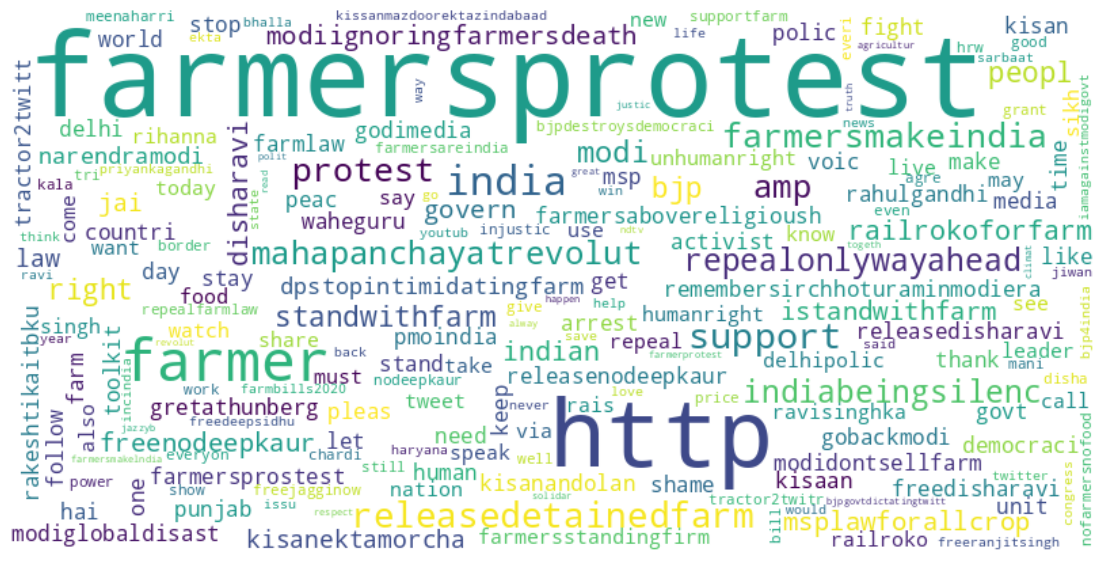

In [ ]:
# Generating a word cloud
words_wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(vocab_dict)

plt.figure(figsize=(14,8))
plt.imshow(words_wc, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
# Creating a new dataframe sorted by the number of retweets
rts_df = tweets_df.copy()
rts_sorted = rts_df.sort_values(by='Retweets', ascending=False)
print('The following are the Top 5 Most Retweeted Tweets:')
rts_sorted.reset_index().drop(columns=['ID', 'URL']).head(5)

Following are the top 5 most retweeted tweets:


,Content,Date,Likes,Retweets,Hastags
0,200 farmlaw farmersprotest,2021-02-12,25824,7723,"[#FarmLaws, #FarmersProtest, #किसान_एकता_जिंदा..."
1,farmersprotest happen germani german govt bloc...,2021-02-23,27888,6164,[#FarmersProtest]
2,disha ravi climat activist arrest delhi polic ...,2021-02-14,8974,4673,"[#farmersprotest., #freedisharavi]"
3,disha ravi broke court room told judg mere edi...,2021-02-14,10403,3742,[#FarmersProtest]
4,farmer sweet see amandacerni rihanna farmerspr...,2021-02-12,17325,3332,"[#FarmersProtest, #ModiWhereAreMissingFarmers,..."
